<a href="https://colab.research.google.com/github/mintseok/MachineLearning/blob/main/Deep_Learning_From_Scratch_3/%EC%A0%9C3%EA%B3%A0%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/밑시딥3/deep-learning-from-scratch-3

/content/drive/MyDrive/밑시딥3/deep-learning-from-scratch-3


# step 24까지의 내용부터 따라하기

In [3]:
import weakref
import numpy as np
import contextlib


class Config:
    enable_backprop = True


@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)


def no_grad():
    return using_config('enable_backprop', False)


class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)


class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)


class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy


def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)


def rsub(x0, x1):
    x1 = as_array(x1)
    return sub(x1, x0)


class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)


def rdiv(x0, x1):
    x1 = as_array(x1)
    return div(x1, x0)


class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c

        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)


Variable.__add__ = add
Variable.__radd__ = add
Variable.__mul__ = mul
Variable.__rmul__ = mul
Variable.__neg__ = neg
Variable.__sub__ = sub
Variable.__rsub__ = rsub
Variable.__truediv__ = div
Variable.__rtruediv__ = rdiv
Variable.__pow__ = pow

x = Variable(np.array(2.0))
y = -x
print(y)  # variable(-2.0)

y1 = 2.0 - x
y2 = x - 1.0
print(y1)  # variable(0.0)
print(y2)  # variable(1.0)

y = 3.0 / x
print(y)  # variable(1.5)

y = x ** 3
y.backward()
print(y)  # variable(8.0)

variable(-2.0)
variable(0.0)
variable(1.0)
variable(1.5)
variable(8.0)


In [4]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
from dezero import Variable


def sphere(x, y):
    z = x ** 2 + y ** 2
    return z


def matyas(x, y):
    z = 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y
    return z


def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z


x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)  # sphere(x, y) / matyas(x, y)
z.backward()
print(x.grad, y.grad)

variable(-5376.0) variable(8064.0)


# graphviz

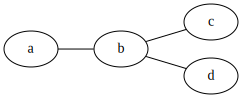

In [41]:
import graphviz 

def save_graph_as_svg(dot_string, output_file_name):
    if type(dot_string) is str:
        g = graphviz.Source(dot_string)
    elif isinstance(dot_string, (graphviz.dot.Digraph, graphviz.dot.Graph)):
        g = dot_string
    g.format='svg'
    g.filename = output_file_name
    g.directory = '../../assets/images/markdown_img/'
    g.render(view=False)
    return g
dot_graph = """
graph graphname {
    rankdir=LR;
     a -- b -- c;
     b -- d;
}"""
save_graph_as_svg(dot_graph, 'simple_dot_example1')

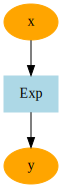

In [44]:
dot_digraph = """
digraph graphname {
  1 [label="x", color=orange, style=filled]
  2 [label="y", color=orange, style=filled]
  3 [label="Exp", color=lightblue, style=filled, shape=box]
  1 -> 3
  3 -> 2
}
"""
save_graph_as_svg(dot_digraph, 'simple_digraph')

digraph g {
139743438117584 [label="y", color=orange, style=filled]
139743438118736 [label="Add", color=lightblue, style=filled, shape=box]
139743436461840 -> 139743438118736
139743436690896 -> 139743438118736
139743438118736 -> 139743438117584
139743436461840 [label="x0", color=orange, style=filled]
139743436690896 [label="x1", color=orange, style=filled]
}


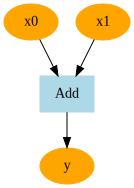

In [49]:
import numpy as np
from dezero import Variable
from dezero.utils import get_dot_graph

x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1

x0.name = 'x0'
x1.name = 'x1'
y.name = 'y'

txt = get_dot_graph(y, verbose=False)
print(txt)

with open('sample.dot', 'w') as o:
  o.write(txt)
  
with open('sample.dot') as o:
  dotGraph = o.read()
graphviz.Source(dotGraph)

In [54]:
def _dot_var(v, verbose=False):
  dot_var = '{} [label="{}", color=orange, style=filled]\n'

  name = '' if v.name is None else v.name
  if verbose and v.data is not None:
    if v.name is not None:
      name += ': '
    name += str(v.shape) + ' ' + str(v.dtype)
  return dot_var.format(id(v), name)

In [55]:
x = Variable(np.random.randn(2, 3))
x.name = 'x'
print(_dot_var(x))
print(_dot_var(x, verbose=True))

139743368250960 [label="x", color=orange, style=filled]

139743368250960 [label="x: (2, 3) float64", color=orange, style=filled]



In [59]:
def _dot_func(f):
  dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
  txt = dot_func.format(id(f), f.__class__.__name__)

  dot_edge = '{} -> {}\n'
  for x in f.inputs:
    txt += dot_edge.format(id(x), id(f))
  for y in f.outputs:
    txt += dot_edge.format(id(f), id(y)) # y는 약한 참조 weakref
  return txt

In [60]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1
txt = _dot_func(y.creator)
print(txt)

139743367710352 [label="Add", color=lightblue, style=filled, shape=box]
139743367712400 -> 139743367710352
139743367709392 -> 139743367710352
139743367710352 -> 139743367713712



In [71]:
def get_dot_graph(output, verbose=True):
  txt = ''
  funcs = []
  seen_set = set()

  def add_func(f):
    if f not in seen_set:
      funcs.append(f)
      seen_set.add(f)

  add_func(output.creator)
  txt += _dot_var(output, verbose)

  while funcs:
    func = funcs.pop()
    txt += _dot_func(func)
    for x in func.inputs:
      txt += _dot_var(x, verbose)

      if x.creator is not None:
        add_func(x.creator)
  return 'digraph graphname {\n' + txt + '}'

In [81]:
def plot_dot_graph(output, verbose=True, to_file="step26"):
  dot_graph= get_dot_graph(output, verbose)
  save_graph_as_svg(dot_graph, to_file)
  g = graphviz.Source(dot_graph)
  return g

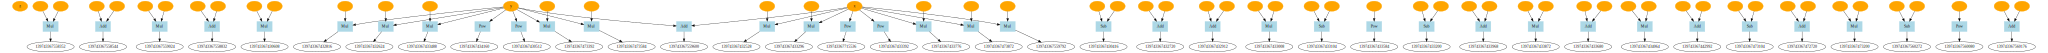

In [82]:
import numpy as np
from dezero import Variable
# from dezero.utils import plot_dot_graph

def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='goldstein.svg')

In [83]:
import numpy as np
import math
from dezero import Variable, Function

class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx


def sin(x):
    return Sin()(x)


x = Variable(np.array(np.pi / 4))
y = sin(x)
y.backward()
print('--- original sin ---')
print(y.data)
print(x.grad)

--- original sin ---
0.7071067811865475
variable(0.7071067811865476)


In [84]:
def my_sin(x, threshold=0.0001):
    y = 0
    for i in range(100000):
        c = (-1) ** i / math.factorial(2 * i + 1)
        t = c * x ** (2 * i + 1)
        y = y + t
        if abs(t.data) < threshold:
            break
    return y


x = Variable(np.array(np.pi / 4))
y = my_sin(x)  # , threshold=1e-150)
y.backward()
print('--- approximate sin ---')
print(y.data)
print(x.grad)

--- approximate sin ---
0.7071064695751781
variable(0.7071032148228457)


In [89]:
import numpy as np
from dezero import Variable
# import dezero's simple_core explicitly
import dezero
if not dezero.is_simple_core:
    from dezero.core_simple import Variable
    from dezero.core_simple import setup_variable
    setup_variable()

def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y


x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad)

-2.0 400.0


In [ ]:
def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y


x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 1000

for i in range(iters):
    print(x0, x1)

    y = rosenbrock(x0, x1)

    x0.cleargrad()
    x1.cleargrad()
    y.backward()

    x0.data -= lr * x0.grad
    x1.data -= lr * x1.grad

In [90]:
def f(x):
    y = x ** 4 - 2 * x ** 2
    return y


def gx2(x):
    return 12 * x ** 2 - 4


x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward()

    x.data -= x.grad / gx2(x.data)

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


In [91]:
class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False, create_graph=False):
        if self.grad is None:
            # self.grad = np.ones_like(self.data)
            self.grad = Variable(np.ones_like(self.data))

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            
            with using_config('enable_backprop', create_graph):
              gxs = f.backward(*gys)
              if not isinstance(gxs, tuple):
                  gxs = (gxs,)

              for x, gx in zip(f.inputs, gxs):
                  if x.grad is None:
                      x.grad = gx
                  else:
                      x.grad = x.grad + gx

                  if x.creator is not None:
                      add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref

In [92]:
# =============================================================================
# 사칙연산 / 연산자 오버로드
# =============================================================================
class Add(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        y = x0 + x1
        return y

    def backward(self, gy):
        gx0, gx1 = gy, gy
        if self.x0_shape != self.x1_shape:  # for broadcaset
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gx0, gx1


def add(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs
        gx0 = gy * x1
        gx1 = gy * x0
        if x0.shape != x1.shape:  # for broadcast
            gx0 = dezero.functions.sum_to(gx0, x0.shape)
            gx1 = dezero.functions.sum_to(gx1, x1.shape)
        return gx0, gx1


def mul(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Mul()(x0, x1)


class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)


class Sub(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        y = x0 - x1
        return y

    def backward(self, gy):
        gx0 = gy
        gx1 = -gy
        if self.x0_shape != self.x1_shape:  # for broadcast
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gx0, gx1


def sub(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Sub()(x0, x1)


def rsub(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Sub()(x1, x0)


class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        if x0.shape != x1.shape:  # for broadcast
            gx0 = dezero.functions.sum_to(gx0, x0.shape)
            gx1 = dezero.functions.sum_to(gx1, x1.shape)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Div()(x0, x1)


def rdiv(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Div()(x1, x0)


class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x, = self.inputs
        c = self.c
        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)

def setup_variable():
    Variable.__add__ = add
    Variable.__radd__ = add
    Variable.__mul__ = mul
    Variable.__rmul__ = mul
    Variable.__neg__ = neg
    Variable.__sub__ = sub
    Variable.__rsub__ = rsub
    Variable.__truediv__ = div
    Variable.__rtruediv__ = rdiv
    Variable.__pow__ = pow
    Variable.__getitem__ = dezero.functions.get_item

    Variable.matmaul = dezero.functions.matmul
    Variable.dot = dezero.functions.matmul
    Variable.max = dezero.functions.max
    Variable.min = dezero.functions.min

In [96]:
import numpy as np
from dezero import Variable

def f(x):
  y = x ** 4 - 2 * x ** 2
  return y

x = Variable(np.array(2.0))
y = f(x)
# first back prop
y.backward(create_graph=True)
print(x.grad)
# second back prop
gx = x.grad
x.cleargrad()
gx.backward()
print(x.grad) # before = 68 = 24 + 44

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward(create_graph=True)

    gx = x.grad
    x.cleargrad()
    gx.backward()
    gx2 = x.grad

    x.data -= gx.data / gx2.data

variable(24.0)
variable(44.0)
0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


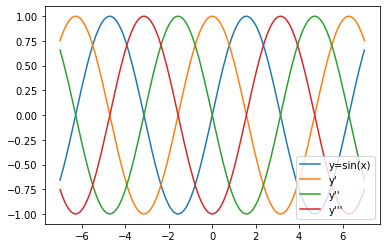

In [97]:
# sin cos 함수 고차미분
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F

x = Variable(np.linspace(-7, 7, 200))
y = F.sin(x)
y.backward(create_graph=True)

logs = [y.data]

for i in range(3):
    logs.append(x.grad.data)
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i, v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc='lower right')
plt.show()

In [98]:
class Tanh(Function):
  def forward(self, x):
    y = np.tanh(x)
    return y
  
  def backward(self, gy):
    y = self.outputs[0]()
    gx = gy * (1 - y * y)
    return gx

def tanh(x):
  return Tanh()(x)

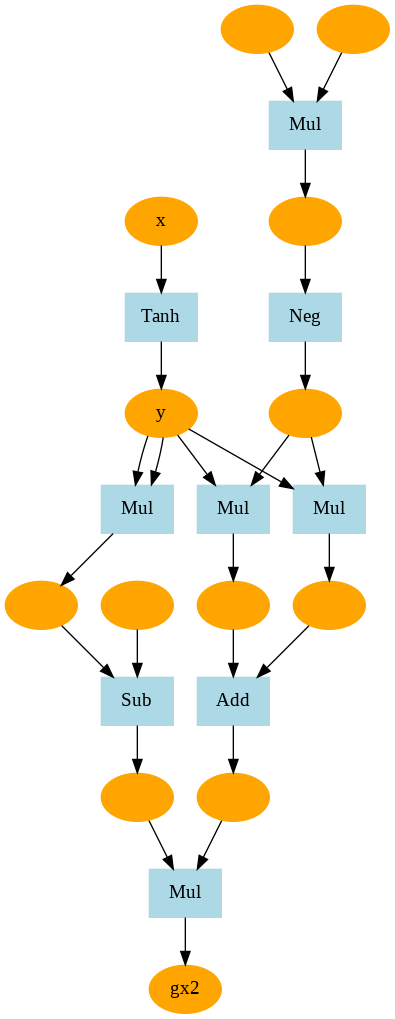

In [99]:
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph
import dezero.functions as F

x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
y.backward(create_graph=True)

iters = 1

for i in range(iters):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

gx = x.grad
gx.name = 'gx' + str(iters + 1)
plot_dot_graph(gx, verbose=False, to_file='tanh.png')

In [100]:
x = Variable(np.array(2.0))
y = x ** 2
y.backward(create_graph=True)
gx = x.grad
x.cleargrad()

z = gx ** 3 + y
z.backward()
print(x.grad)

variable(100.0)
